In [1]:
import torch
from torch_geometric.nn import GCNConv, ChebConv  # noqa
import time
import networkx as nx
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from importlib import reload
from best_params import best_params_dict
import data as dt

/users/s1f101810026/miniconda3/envs/grand/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import importlib
# importlib.reload(sys.modules['grand_discritized'])
# importlib.reload(sys.modules['run_grand_ex'])
from grand_discritized import GrandExtendDiscritizedNet
from run_grand_ex import get_optimizer, train, test


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
opt = {'depth': 256, 'trunc_alpha': 0, 'discritize_type':'norm', 'step_size':0.1, 'one_block':True}
best_opt = best_params_dict['Cora']
opt = {**opt, **best_opt}
opt['epoch'] = 200
opt['hidden_dim'] = 80
opt['batch_norm'] = False

In [4]:
# dataset = dt.get_dataset('Cora', '../data', use_lcc=True)
dataset = dt.get_dataset(opt, '../data', opt['not_lcc'])
# dataset = dt.get_dataset({'dataset':'Cora', 'rewiring' : None}, '/content/graph-neural-pde/data', use_lcc=True) 
print(dataset.data.num_nodes, dataset.data.num_edges)

2485 10138


In [5]:
model, dat = GrandExtendDiscritizedNet(opt, dataset, device).to(device), dataset.data.to(device)

In [6]:
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = get_optimizer(opt['optimizer'], parameters, lr=opt['lr'], weight_decay=opt['decay'])

In [7]:
import tqdm

best_val_acc = test_acc = best_epoch = 0
for epoch in tqdm.tqdm(range(1, opt['epoch'])):
    start_time = time.time()

    loss = train(model, optimizer, dat)
    [train_acc, val_acc, tmp_test_acc], outs = test(model, dat)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
        best_epoch = epoch
        best_outs = outs
    # log = 'Epoch: {:03d}, Runtime {:03f}, Loss {:03f}, forward nfe {:d}, backward nfe {:d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    # print(
    #   log.format(epoch, time.time() - start_time, loss, model.fm.sum, model.bm.sum, train_acc, best_val_acc, test_acc))
    # print('best val accuracy {:03f} with test accuracy {:03f} at epoch {:d}'.format(best_val_acc, test_acc, best_epoch))

100%|█████████████████████████████████████████████████████████████████████████████████| 199/199 [03:10<00:00,  1.05it/s]


In [8]:
print(train_acc, test_acc, best_epoch)

0.9 0.8629441624365483 167


In [9]:
len(best_outs[1])

769

(array([1.015e+03, 5.700e+01, 5.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.1531267,  4.7755947,  8.398063 , 12.020531 , 15.642999 ,
        19.265467 , 22.887936 , 26.510403 , 30.132872 , 33.75534  ,
        37.377808 ], dtype=float32),
 <BarContainer object of 10 artists>)

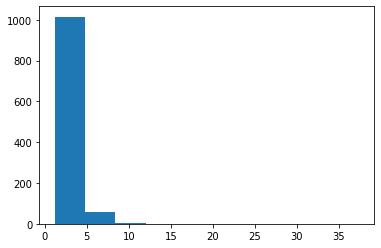

In [10]:
check = np.array([torch.norm(out, dim=-1).cpu().numpy() for out in best_outs[1]])
plt.hist(check[10,dat.cpu().val_mask])

In [11]:
best_outs[1][opt['depth']].corrcoef()

tensor([[1.0000, 0.4778, 0.7270,  ..., 0.6159, 0.9814, 0.9810],
        [0.4778, 1.0000, 0.9412,  ..., 0.8125, 0.4979, 0.4971],
        [0.7270, 0.9412, 1.0000,  ..., 0.9031, 0.7534, 0.7524],
        ...,
        [0.6159, 0.8125, 0.9031,  ..., 1.0000, 0.7077, 0.7041],
        [0.9814, 0.4979, 0.7534,  ..., 0.7077, 1.0000, 0.9998],
        [0.9810, 0.4971, 0.7524,  ..., 0.7041, 0.9998, 1.0000]],
       device='cuda:0')

In [12]:
torch.norm(best_outs[1][0][10],dim=-1)

tensor(3.0440, device='cuda:0')

In [13]:
len(best_outs[1])

769

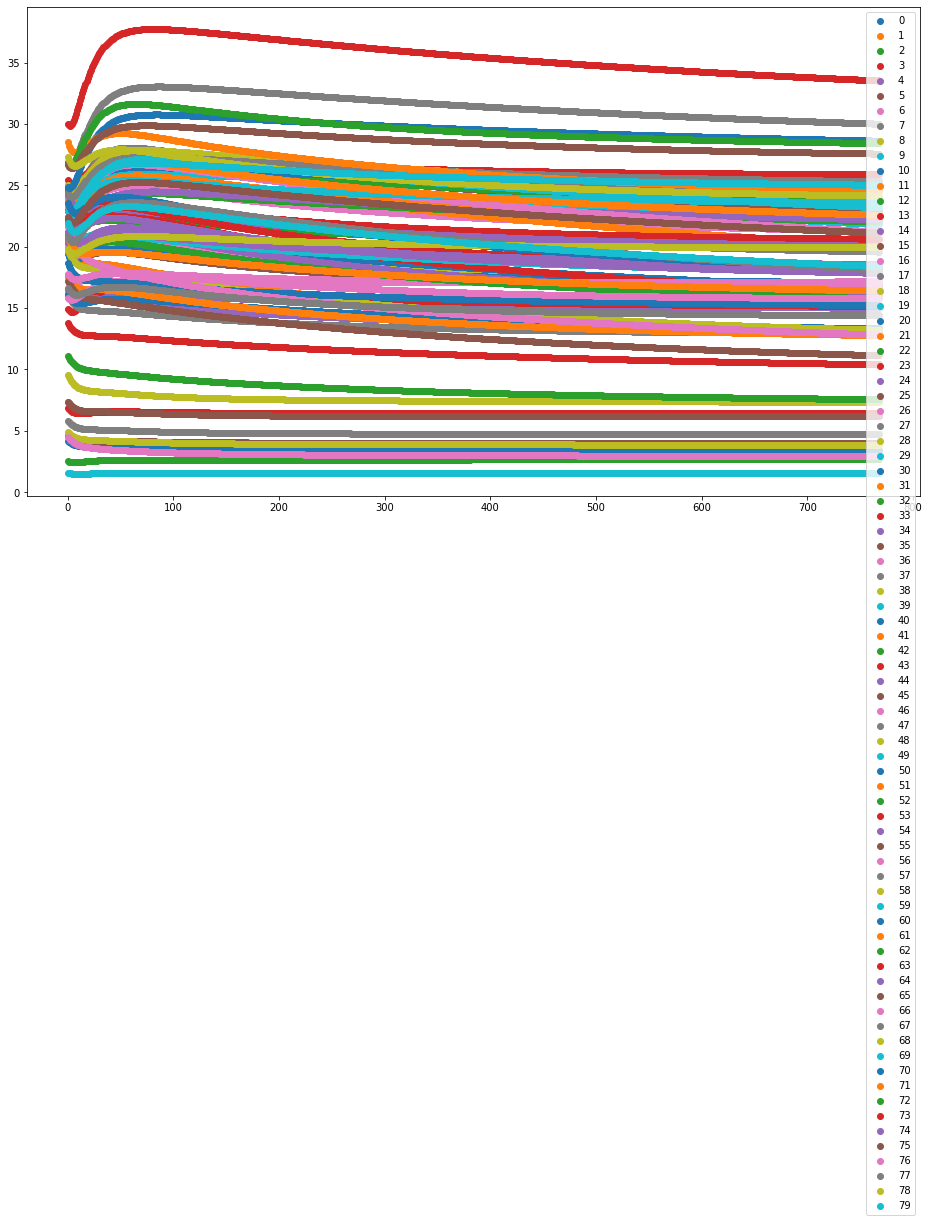

In [14]:
#Norm of hidden_dim
plt.figure(figsize=(16, 9))
for dim in range(opt['hidden_dim']):
    plt.scatter([i for i in range(opt['depth']*3+1)],[torch.norm(out,dim=0)[dim].cpu().numpy() for out in best_outs[1]], label=dim)

plt.legend()

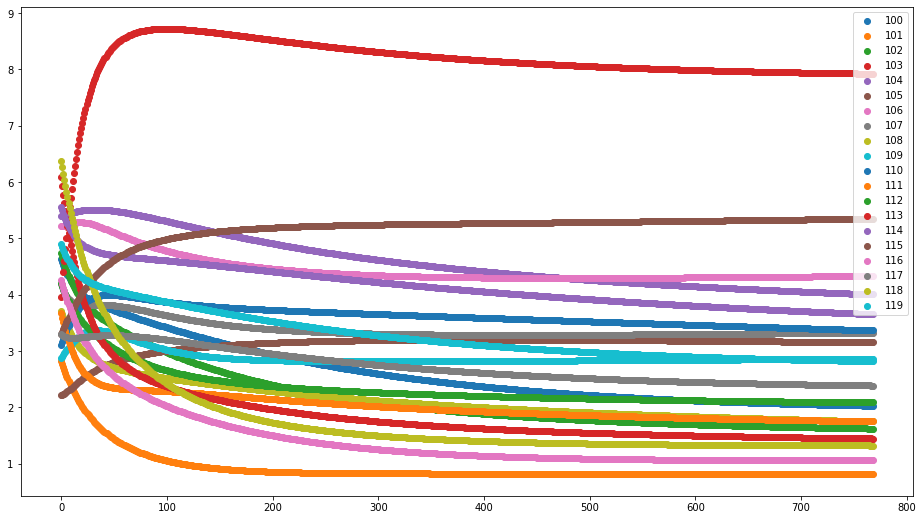

In [15]:
#Norm of first 10 nodes
plt.figure(figsize=(16, 9))
start = 100
end = start+20
for node in range(start,end):
    plt.scatter([i for i in range(opt['depth']*3+1)],[torch.norm(out[node],dim=-1).cpu().numpy() for out in best_outs[1]], label=node)

plt.legend()

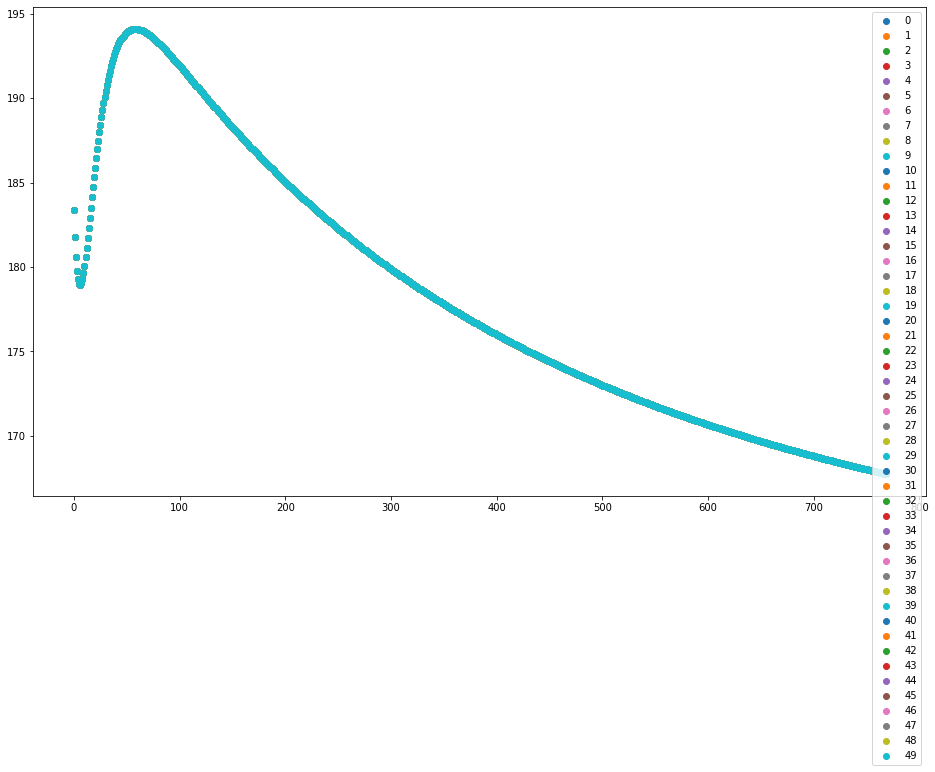

In [16]:
#Norm all
plt.figure(figsize=(16, 9))
#2485
for dim in range(50):
    plt.scatter([i for i in range(opt['depth']*3+1)][0:],[torch.norm(out).cpu().numpy() for out in best_outs[1]][0:], label=dim)

plt.legend()

In [17]:
8|11

11

/users/s1f101810026/miniconda3/envs/grand/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/users/s1f101810026/miniconda3/envs/grand/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15380 samples in 0.001s...
[t-SNE] Computed neighbors for 15380 samples in 1.805s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15380
[t-SNE] Computed conditional probabilities for sample 2000 / 15380
[t-SNE] Computed conditional probabilities for sample 3000 / 15380
[t-SNE] Computed conditional probabilities for sample 4000 / 15380
[t-SNE] Computed conditional probabilities for sample 5000 / 15380
[t-SNE] Computed conditional probabilities for sample 6000 / 15380
[t-SNE] Computed conditional probabilities for sample 7000 / 15380
[t-SNE] Computed conditional probabilities for sample 8000 / 15380
[t-SNE] Computed conditional probabilities for sample 9000 / 15380
[t-SNE] Computed conditional probabilities for sample 10000 / 15380
[t-SNE] Computed conditional probabilities for sample 11000 / 15380
[t-SNE] Computed conditional probabilities for sample 12000 / 15380
[t-SNE] Computed conditional probabilities for sa

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[t-SNE] KL divergence after 300 iterations: 2.260637


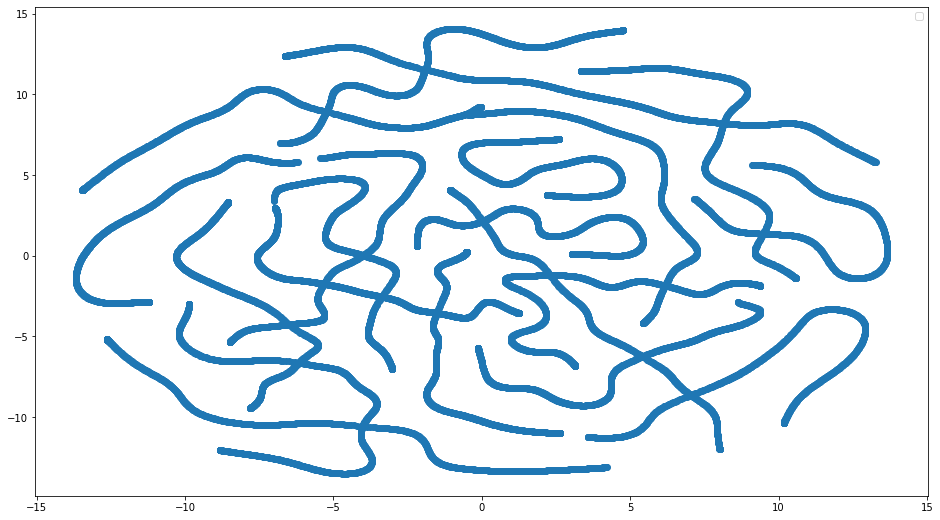

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#dynamic of 10 nodes, 0 and 1 features
plt.figure(figsize=(16, 9))
#2485
start = 100
end = start+20
data = []
label = []
for node in range(start,end):
    data.extend([out[node].cpu().numpy() for out in best_outs[1]])
    label.extend([node for _ in range(opt['depth']*3 + 1)])
pca = PCA(n_components=2)
pca.fit(data)
# plt.scatter(pca_result[:,0], pca_result[:,1])

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data)
plt.scatter(tsne_results[:,0], tsne_results[:,1])
# for node in range(start,end):
#     pca_result = pca.transform([out[node].cpu().numpy() for out in best_outs[1]][0:])
# # df['pca-one'] = pca_result[:,0]
# # df['pca-two'] = pca_result[:,1] 
#     plt.scatter(pca_result[:,0], pca_result[:,1], label=node)

#     # plt.scatter([out[node+10][0].cpu().numpy() for out in best_outs[1]][0:],[out[node+10][1].cpu().numpy() for out in best_outs[1]][0:], label=dim)

plt.legend()

In [19]:
len(label)

15380

In [20]:
values = best_outs[2][0].mean(dim=1)
att = torch.zeros(2485,2485)

for idx in range(len(best_outs[2][1][0])):
    row = best_outs[2][1][0][idx]
    col = best_outs[2][1][1][idx]
    att[col][row] = values[idx]

In [21]:
torch.eig(att.cpu()-torch.transpose(att.cpu(),0,1))

/tmp/ipykernel_1329207/1855845895.py:1: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2910.)
  torch.eig(att.cpu()-torch.transpose(att.cpu(),0,1))


torch.return_types.eig(
eigenvalues=tensor([[-2.4855e-08,  2.5372e+00],
        [-2.4855e-08, -2.5372e+00],
        [-4.0978e-08,  2.5263e+00],
        ...,
        [-2.8584e-10,  1.0660e-09],
        [-2.8584e-10, -1.0660e-09],
        [-7.7926e-11,  0.0000e+00]]),
eigenvectors=tensor([]))

In [22]:
test = torch.randint(3,10,(3,3)).float()
torch.linalg.eigvals(test - torch.transpose(test,0,1))

tensor([-1.0388e-08+0.0000j, -1.7881e-07+3.3166j, -1.7881e-07-3.3166j])

In [23]:
test - torch.transpose(test,0,1)

tensor([[ 0., -1.,  1.],
        [ 1.,  0., -3.],
        [-1.,  3.,  0.]])

In [24]:
test = torch.Tensor([[0.2,0.8],[0.1,0.9]])
torch.eig(test - torch.transpose(test,0,1))

torch.return_types.eig(
eigenvalues=tensor([[ 0.0000,  0.7000],
        [ 0.0000, -0.7000]]),
eigenvectors=tensor([]))

In [25]:
test = att-torch.transpose(att,0,1)